# Pre-TP2: Grafos en neuro

## 1. Introducción
El análisis de la topología de grafos (es decir, redes) es un área de investigación que atañe a diferentes campos de estudio. Para ejemplificar el uso de grafos nos enfocaremos en el los datos obtenidos en el trabajo de Tagliazucchi y colaboradores (2013) que busca relacionar cambios en la modularidad de las redes construidas a partir de la señal de resonancia
magnética funcional (fMRI) con los distintos estadíos del sueño.

## 2. Objetivos
Familiarizarse con la generación de grafos que representen un conjunto de datos. Visualizar, manipular y comparar distintos grafos. Calcular parámetros básicos de un grafo, y compararlos con modelos de redes random, small world y scale-free.

## 3. Estructuctura de los datos
En la carpeta DataSujetos se encuentran los archivos separados por cada sujeto y estadio del sueño bajo la siguiente notación [Estadio del sueño]_[Número de sujeto].csv. Para cada sujeto y estadío de sueño encontraremos una matriz de correlaciones de tamaño 116x116 con las correlaciones entre las señales BOLD de 116 regiones cerebrales. Además se incluyen los nombres y coordenadas de las 116 regiones en un archivo apar- te: aalextendedwithCoords.csv. Estas regiones están definidas a partir del atlas Automatic Anatomical Labeling (AAL)

In [328]:
# !wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip -O ../../data/raw/DataSujetos.zip
# !unzip -q ../../data/raw/DataSujetos.zip -d ../../data/interim/
# !wget -q https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws -O ../../data/raw/aal_extended_withCoords.csv

In [329]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

In [330]:
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

RegionsNames = pd.read_csv("../../data/raw/aal_extended_withCoords.csv", header=None, index_col=0)
RegionsNames.head()

layout=dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

In [331]:
def density_to_th(W, d):
    n=W.shape[0]
    max_links = (n*(n-1))//2
    print(max_links)
    tril_idx = np.tril_indices(n,-1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*d)]

In [332]:
def get_graph_metrics(graph):
    df_degree = pd.DataFrame(graph.degree,columns=['Node','Degree']).set_index('Node')
    k_mean = df_degree["Degree"].mean()
    k_max = df_degree["Degree"].max()
    
    ci = nx.clustering(graph)
    df_per_clustering = pd.DataFrame(ci.items(),columns=['Node','Clustering']).set_index('Node')
    ci_mean = df_per_clustering['Clustering'].mean()
    
    eff = nx.global_efficiency(graph)
    
    return k_mean, k_max, ci_mean, eff

## 4. Preprocesamiento de los datos
- Cargar el dataset con los datos para cada sujeto y los nombres y coordenadas de las regiones cerebrales a las que se les registró la actividad.

In [333]:
files = os.listdir('../../data/interim/DataSujetos/')
print(files[0:5])

['N3_suj18.csv', 'N2_suj8.csv', 'N3_suj8.csv', 'N3_suj9.csv', 'N2_suj9.csv']


In [334]:
sujetos_dfs = []

for file in files:
    df_temp = pd.read_csv('../../data/interim/DataSujetos/' + file, header=None)
    df_temp['file'] = file
    df_temp[['estado_sueno', 'sujeto']] = df_temp['file'].str.split('_', expand=True)
    df_temp['sujeto'] = df_temp['sujeto'].str.replace('.csv', '').str.replace('suj', '')
    sujetos_dfs.append(df_temp)

df = pd.concat(sujetos_dfs, axis=0, ignore_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,file,estado_sueno,sujeto
0,1.00000,0.75228,0.59672,0.61720,0.61036,0.58281,0.62356,0.60070,0.48458,0.42477,...,0.36404,0.41587,0.37399,0.52954,0.59884,0.48292,0.098455,N3_suj18.csv,N3,18
1,0.75228,1.00000,0.43057,0.57711,0.46849,0.45001,0.42769,0.51553,0.39334,0.36685,...,0.47406,0.51675,0.44855,0.59525,0.75812,0.61522,0.143240,N3_suj18.csv,N3,18
2,0.59672,0.43057,1.00000,0.78695,0.71494,0.62041,0.88456,0.67340,0.63665,0.46685,...,0.28807,0.30319,0.23167,0.37021,0.39687,0.41879,0.269630,N3_suj18.csv,N3,18
3,0.61720,0.57711,0.78695,1.00000,0.60188,0.60783,0.77913,0.77403,0.52327,0.44301,...,0.31306,0.46552,0.44312,0.55917,0.52748,0.54166,0.153890,N3_suj18.csv,N3,18
4,0.61036,0.46849,0.71494,0.60188,1.00000,0.80111,0.70464,0.62453,0.83012,0.70528,...,0.31729,0.34996,0.27957,0.39880,0.47443,0.42913,0.205490,N3_suj18.csv,N3,18


- Reportar cuántos sujetos y cuántos estados de sueño se observan en el conjunto de datos.

In [335]:
df.groupby(['estado_sueno'], as_index=False).agg({"sujeto": "nunique"})

,estado_sueno,sujeto
0,N1,18
1,N2,18
2,N3,18
3,W,18


- `W` hace referencia al estado `wake` (despierto) del sujeto y 18 sujetos para esta condición.
- Hay tres estados del sueño (`N1`, `N2` & `N3`) y 18 sujetos por cada estado del sueño.

## 5. Manipulación de datos

- Graficar la matriz de correlaciones entre regiones (es decir, la "matriz de adyacencia pesada") para el `sujeto 2` de la condición despierto ("Wake")

In [336]:
df_sujeto_2 = df[(df['sujeto'] == '2') & (df['estado_sueno'] == 'W')]
df_sujeto_2 = df_sujeto_2.reset_index(drop=True)
df_sujeto_2 = df_sujeto_2.drop(['estado_sueno', 'sujeto', 'file'], axis=1)
df_sujeto_2.head()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,1.000000,0.931250,-0.36596,-0.037262,-0.38320,-0.52531,0.22055,0.55746,-0.42691,-0.37738,...,0.65505,0.67698,0.61761,0.72113,0.73791,0.61358,0.39207,0.52388,0.73016,0.624770
1,0.931250,1.000000,-0.36434,-0.047821,-0.39816,-0.51714,0.19599,0.53922,-0.41087,-0.35586,...,0.65411,0.66391,0.62397,0.70520,0.71338,0.61552,0.42667,0.56555,0.71042,0.578120
2,-0.365960,-0.364340,1.00000,0.805290,0.86969,0.91718,0.77668,0.29545,0.88109,0.91498,...,-0.51444,-0.66186,-0.54153,-0.65471,-0.71359,-0.66347,-0.15066,-0.29798,-0.70964,-0.432760
3,-0.037262,-0.047821,0.80529,1.000000,0.71369,0.74156,0.78621,0.67376,0.71059,0.78149,...,-0.30766,-0.44407,-0.33264,-0.34509,-0.35186,-0.47497,-0.22905,-0.13609,-0.29878,-0.055818
4,-0.383200,-0.398160,0.86969,0.713690,1.00000,0.88927,0.59852,0.18166,0.90790,0.89803,...,-0.54662,-0.68150,-0.46798,-0.65440,-0.68123,-0.71640,-0.27918,-0.26101,-0.63446,-0.288370


In [337]:
matAdyacPesada = df_sujeto_2.values
n = matAdyacPesada.shape[0]
matAdyacPesada -= np.diag(np.ones(n))

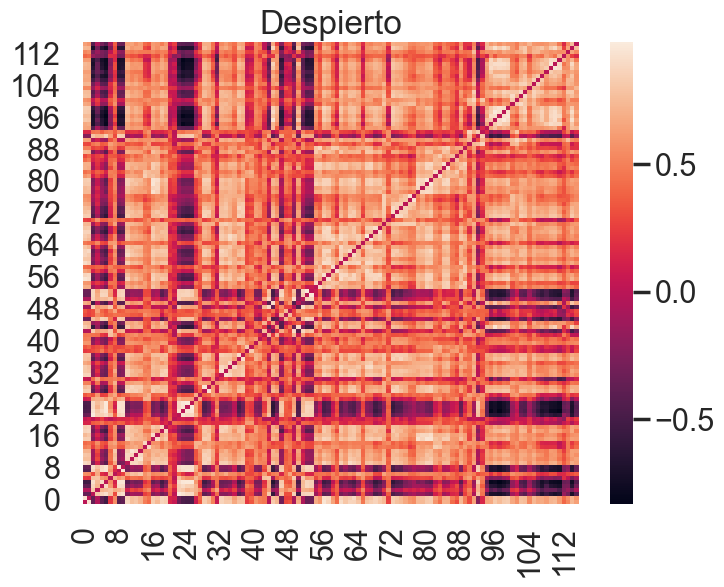

In [387]:
fig = sns.heatmap(matAdyacPesada)
plt.title('Despierto')
plt.xlim(0,n)
plt.ylim(0,n)
plt.show()

fig.get_figure().savefig("static/adjacency_matrix_weighted.png", bbox_inches='tight', transparent=True)

- Seleccionar un umbral de correlación entre regiones: Transformar dicha matriz de adyacencia pesada a una matriz de adyacencia binaria $A_{i,j}$ que represente una una densidad de enlaces $\delta=0.08$. ¿Cuál es el valor de umbral de correlación entre pares de regiones que tuvo que utilizar?

In [388]:
densidad=0.08
thWake=density_to_th(matAdyacPesada, densidad)
print(thWake)

6670
0.77997


In [389]:
matAdyacNoPesada = (matAdyacPesada>=thWake)

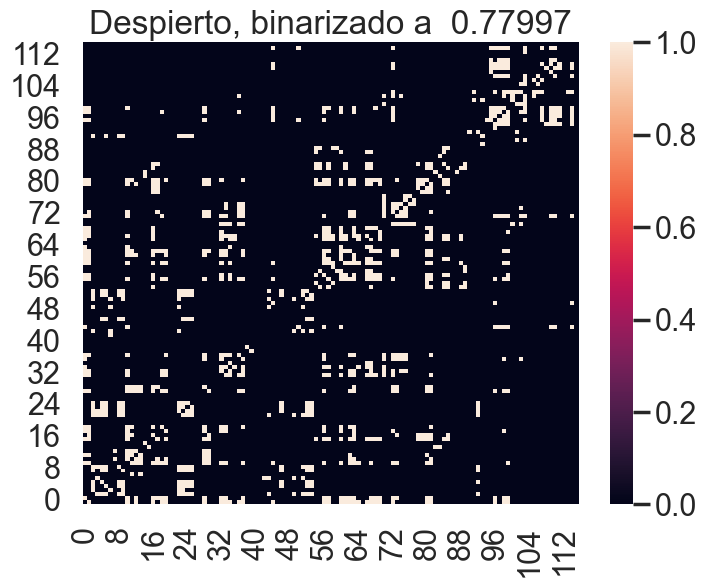

In [390]:
fig = sns.heatmap(matAdyacNoPesada)
plt.xlim(0,n)
plt.ylim(0,n)
plt.title(f'Despierto, binarizado a  {thWake}')
plt.show()

fig.get_figure().savefig("static/adjacency_matrix_binary.png", bbox_inches='tight', transparent=True)

- Utilizando $A_{i,j}$, obtener el grafo resultante $G$.

In [391]:
f = lambda x: 1 if x else 0
vf = np.vectorize(f)
matAdyacNoPesada = vf(matAdyacNoPesada)

In [392]:
G = nx.from_numpy_array(matAdyacNoPesada)

/var/folders/cg/6bd366p92fbb82w4cdb91yd40000gn/T/ipykernel_28088/320749159.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


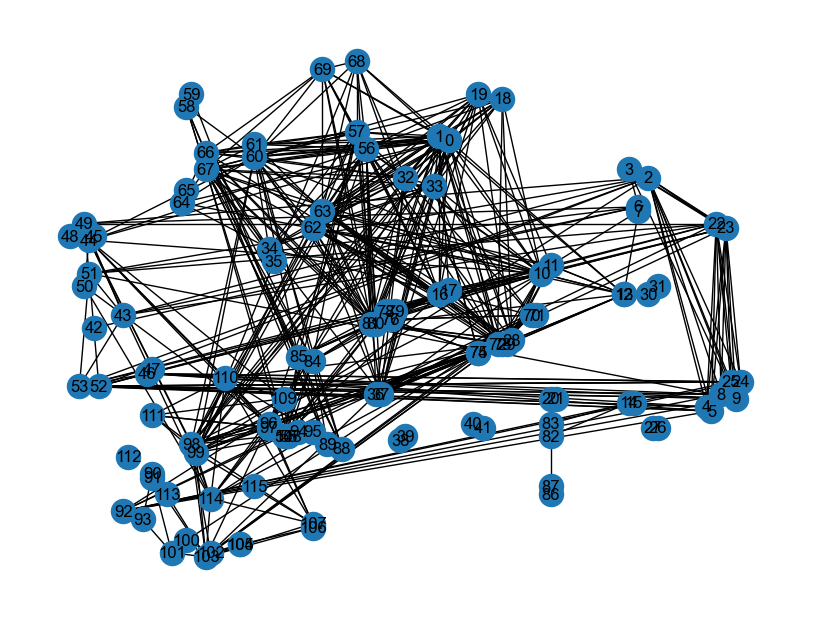

In [393]:
fig = plt.figure(figsize=(8,6))

nx.draw(G, layout, with_labels=True, linewidths =1)

# plt.title('Grafo')
plt.tight_layout()
plt.show()

fig.savefig("static/graph.png", bbox_inches='tight', transparent=True)

- ¿Es $G$ un grafo conectado? ¿Se puede calcular la distancia media entre pares de nodos $d$ del grafo $G$? ¿Si no se puede, qué medida equivalente calcularías?

In [394]:
if nx.is_connected(G):
    print("G es conexo")
else:
    print("G no es conexo")

G no es conexo


En este caso se analiza la mayor componente conexa del grafo $G$.

- Calcular $d$ para cada componente conectado de $G$. Calcular la eficiencia global $eff$ del grafo $G$.

In [395]:
G_connected_list = (G.subgraph(c) for c in nx.connected_components(G))
G_connected_list = list(G_connected_list)

In [396]:
len(G_connected_list)

20

In [348]:
G_connected = G_connected_list[0]

La distancia media o longitud característica $d$ de un grafo es la distancia promedio entre los pares de nodos del grafo. La distancia entre dos nodos es el número de enlaces en el camino más corto que los conecta. Esta distancia se puede calcular para cada componente conexa del grafo con el uso del algoritmo de Floyd-Warshall.

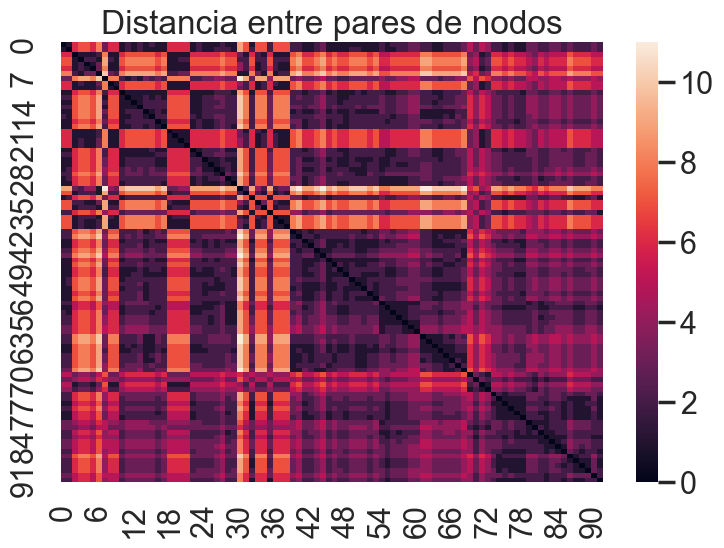

In [397]:
distance = nx.floyd_warshall_numpy(G_connected)

fig = plt.figure(figsize=(8,6))

sns.heatmap(distance)
plt.title('Distancia entre pares de nodos')
plt.tight_layout()
plt.show()

fig.savefig("static/distance.png", bbox_inches='tight', transparent=True)


Una vez se tiene la matriz de distancias, se toma la matriz triangular inferior para calcular:
- Diámetro $D$: la distancia máxima entre un par de nodos.
- Distancia media $d$: el promedio de distancias entre pares de nodos.

In [398]:
diameter = nx.diameter(G_connected)
print(diameter)

11


In [399]:
d = np.mean(np.tril(distance))
print(d)

1.9254489603024574


In [400]:
assert np.max(np.tril(distance)) == nx.diameter(G_connected)

La eficiencia global $eff$ de un grafo es el promedio del inverso de la distancia.  

In [401]:
eff = np.mean(1 / distance[np.triu_indices_from(distance, k=1)])
print(eff)

0.38780454362752503


In [402]:
assert np.isclose(eff, nx.global_efficiency(G_connected))

- Obtener la lista de enlaces del grafo $G$

In [403]:
edges = G.edges()
edges

EdgeView([(0, 1), (0, 10), (0, 12), (0, 16), (0, 18), (0, 19), (0, 28), (0, 32), (0, 33), (0, 34), (0, 36), (0, 37), (0, 44), (0, 56), (0, 57), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 66), (0, 67), (0, 68), (0, 69), (0, 72), (0, 80), (0, 81), (0, 96), (0, 98), (0, 99), (1, 10), (1, 12), (1, 16), (1, 17), (1, 18), (1, 19), (1, 28), (1, 32), (1, 33), (1, 37), (1, 56), (1, 57), (1, 60), (1, 61), (1, 62), (1, 63), (1, 67), (1, 68), (1, 69), (1, 72), (1, 73), (1, 80), (1, 81), (1, 96), (1, 98), (1, 99), (2, 3), (2, 4), (2, 5), (2, 8), (2, 9), (2, 22), (2, 23), (2, 24), (2, 25), (2, 43), (2, 49), (2, 51), (2, 52), (2, 53), (2, 92), (3, 6), (3, 9), (3, 22), (3, 23), (4, 5), (4, 8), (4, 9), (4, 22), (4, 23), (4, 24), (4, 25), (4, 46), (4, 52), (4, 53), (5, 8), (5, 9), (5, 22), (5, 23), (5, 24), (5, 25), (5, 46), (5, 52), (5, 53), (5, 92), (6, 42), (6, 43), (6, 49), (6, 51), (7, 11), (7, 13), (8, 9), (8, 22), (8, 23), (8, 24), (8, 25), (8, 46), (8, 52), (8, 53), (8, 92), (9, 22), (9, 2

- Calcular el grado promedio $< k >$, el nodo con grado máximo $k_{max}$, el coeficiente de *clustering* promedio $C = < C_{i} >$

In [404]:
df_per_degree = pd.DataFrame(G_connected.degree,columns=['Node','Degree']).set_index('Node')

El grado $k$ de un nodo es el número de enlaces que tiene. El grado promedio $< k >$ es el promedio de los grados de todos los nodos del grafo.

In [405]:
print("Grado promedio:", df_per_degree["Degree"].mean())

Grado promedio: 11.478260869565217


El grado máximo $k_{max}$ es el grado más grande de todos los nodos del grafo.

In [406]:
print("Grado máximo:", df_per_degree["Degree"].max())

Grado máximo: 30


In [407]:
node_max = df_per_degree['Degree'].idxmax()
kmax = df_per_degree['Degree'].max()

print("Máximo")
print("Nodo:", node_max) 
print("Grado:", kmax)


Máximo
Nodo: 0
Grado: 30


In [408]:
node_min = df_per_degree['Degree'].idxmin()
kmin = df_per_degree['Degree'].min()
print("Mínimo")
print("Nodo:", node_min) 
print("Grado:", kmin)

Mínimo
Nodo: 42
Grado: 1


La distribución de grado $P(k)$ es la probabilidad de que un nodo elegido al azar tenga grado $k$. La distribución de grado se puede calcular a partir de la lista de grados de los nodos del grafo.

In [409]:
assert kmax == G_connected.degree[node_max]
assert kmin == G_connected.degree[node_min]

El coeficiente de clustering $C_{i}$ de un nodo $i$ es la fracción de pares de vecinos de $i$ que están conectados entre sí. El coeficiente de clustering promedio $\< C \>$ es el promedio de los coeficientes de clustering de todos los nodos del grafo.

In [410]:
ci = nx.clustering(G)

In [411]:
df_per_clustering = pd.DataFrame(ci.items(),columns=['Node','Clustering']).set_index('Node')

In [412]:
ci_mean = df_per_clustering['Clustering'].mean()
print("Coeficiente de clustering promedio:", ci_mean)

Coeficiente de clustering promedio: 0.5270851708219173


- Visualizar el grafo, ubicando los nodos en sus coordenadas cerebrales y coloreando cada nodo de acuerdo a su coeficiente de *clustering* $C_{i}$

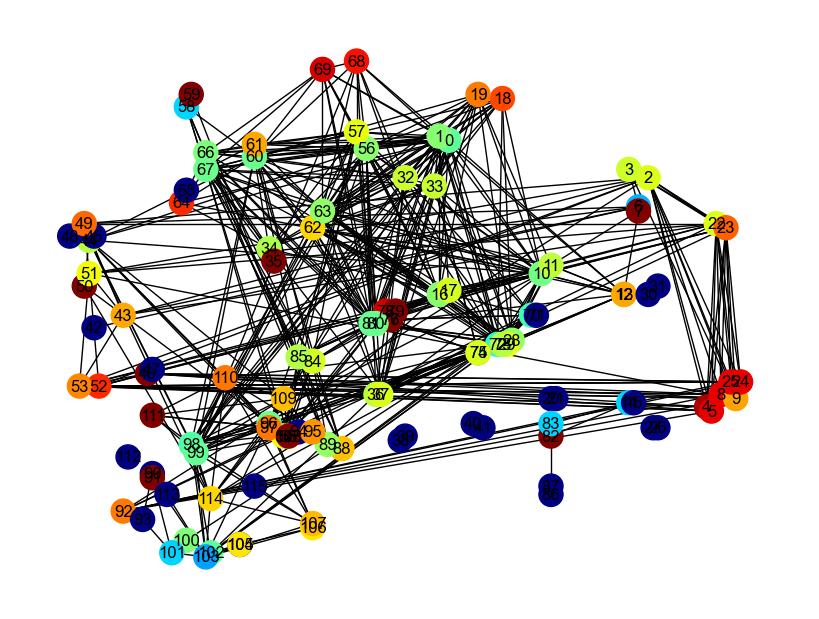

In [413]:
nx.draw(G, layout, with_labels=True, linewidths =1, node_color=list(ci.values()), cmap=plt.cm.jet)

plt.savefig("static/clustering.png", bbox_inches='tight', transparent=True)

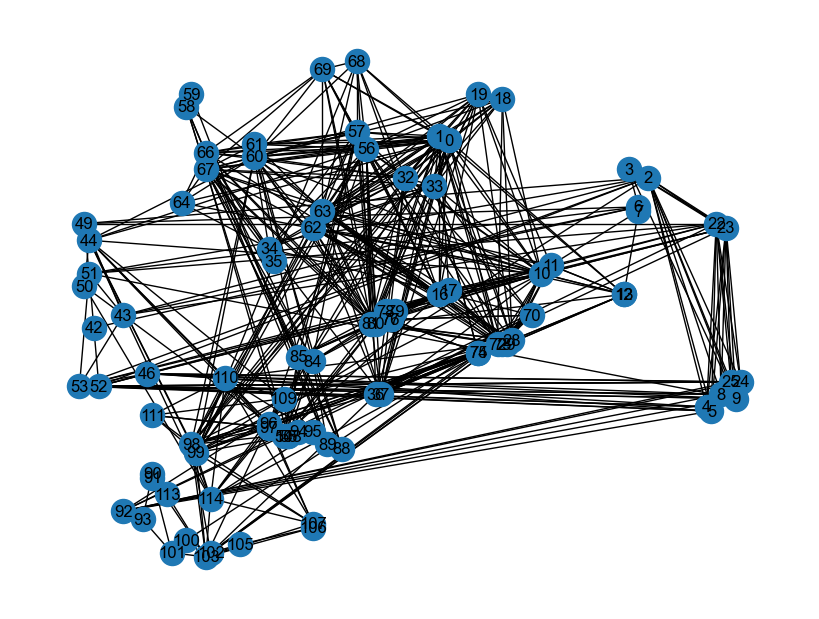

In [414]:
layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

nx.draw(nx.Graph(G_connected_list[0]), layout, with_labels=True, linewidths =1)
plt.savefig("static/first_component.png", bbox_inches='tight', transparent=True)

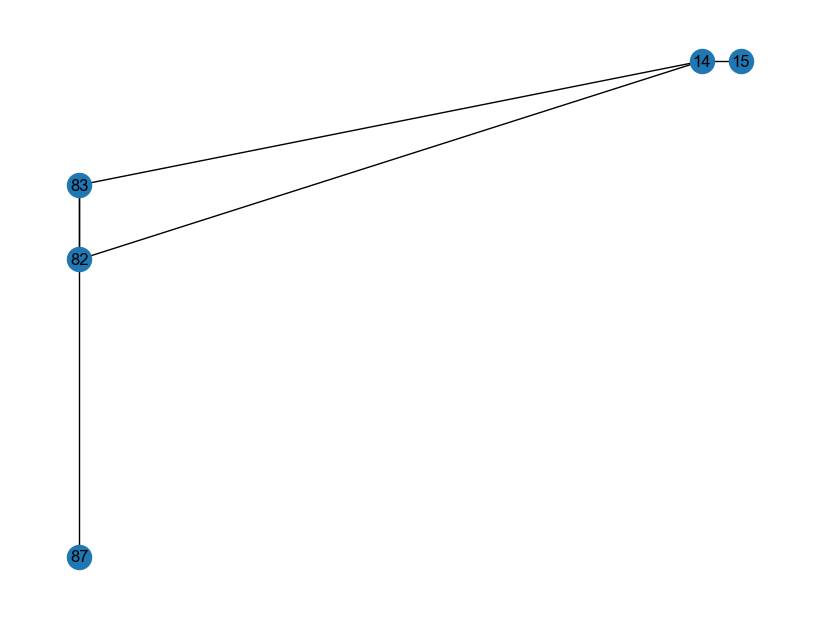

In [415]:
nx.draw(nx.Graph(G_connected_list[1]), layout, with_labels=True, linewidths =1)
plt.savefig("static/second_component.png", bbox_inches='tight', transparent=True)

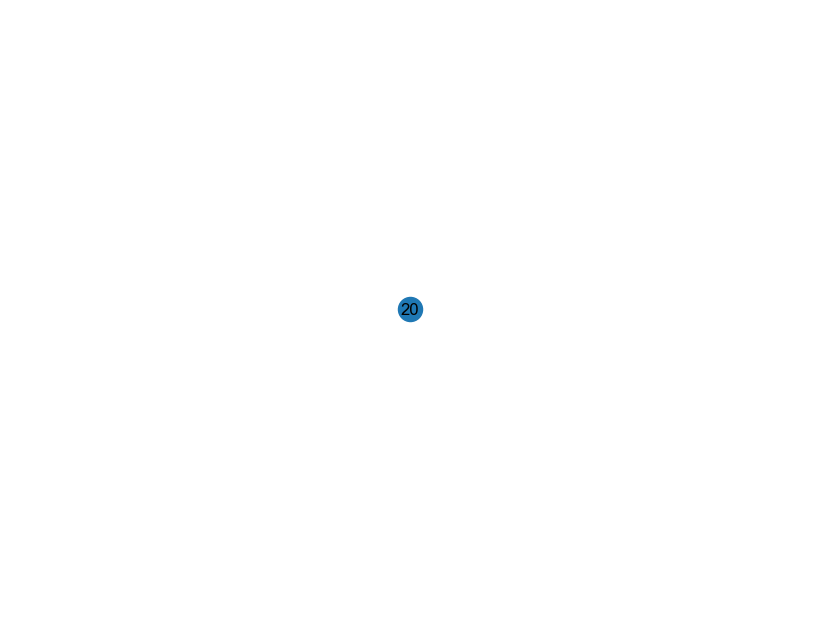

In [416]:
nx.draw(nx.Graph(G_connected_list[2]), layout, with_labels=True, linewidths =1)
plt.savefig("static/third_component.png", bbox_inches='tight', transparent=True)

- Graficar la distribución de grado del grafo, eligiendo un número de bins apropriado

La distribución de grado $P(k)$ es la probabilidad de que un nodo elegido al azar tenga grado $k$. La distribución de grado se puede calcular a partir de la lista de grados de los nodos del grafo.

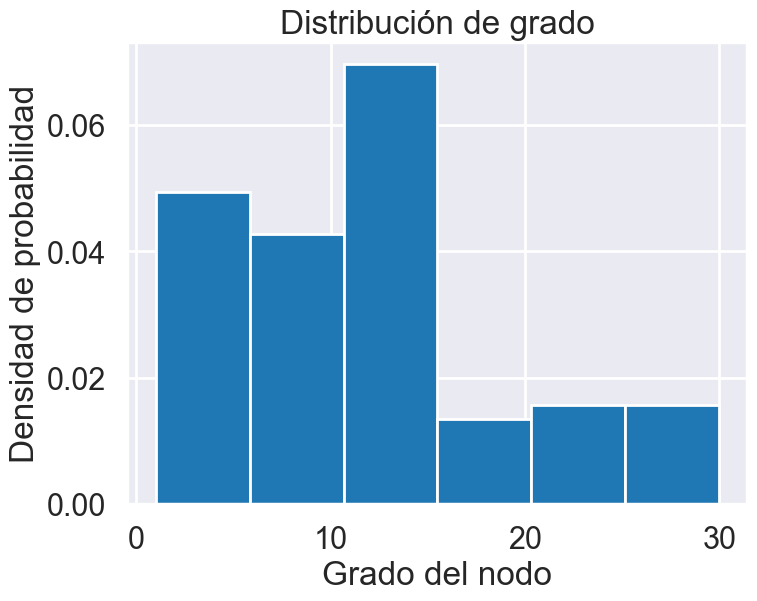

In [423]:
fig, ax = plt.subplots(1,1)
fig = df_per_degree.hist(bins="scott", density=True, ax=ax)
plt.title('Distribución de grado')
plt.ylabel('Densidad de probabilidad')
plt.xlabel('Grado del nodo')
plt.show()

fig = fig[0].get_figure()
fig.savefig("static/degree_dist_connected.png", bbox_inches='tight', transparent=True)

- Vamos a comparar el grafo $G$ con prototipos de redes *poissonianas* (random), *small-World* y *scale-free*, usando los algoritmos de *Erdos-Renyi*, *Watts-Strogatz* y *Barabasi-Albert*, respectivamente. Para ello, elegir (y reportar) los parámetros utilizados para cada algoritmo, buscando siempre que los grafos simulados de dichos prototipos sean comparables al grafo de datos $G$ (en términos de número de nodos y números de enlaces). Visualizar un ejemplo de grafo para cada uno de estos prototipos de redes. Discutir diferencias.

In [370]:
n = G.number_of_nodes()
m = G.number_of_edges()
print(f"n={n}, m={m}")

n=116, m=534


Simular un grado poissonianos con el algoritmo de Erdos-Renyi.

In [371]:
p_poissonian = n / (m * (n - 1) / 2)
poisson_graph = nx.erdos_renyi_graph(n, p_poissonian, seed=RANDOM_STATE)

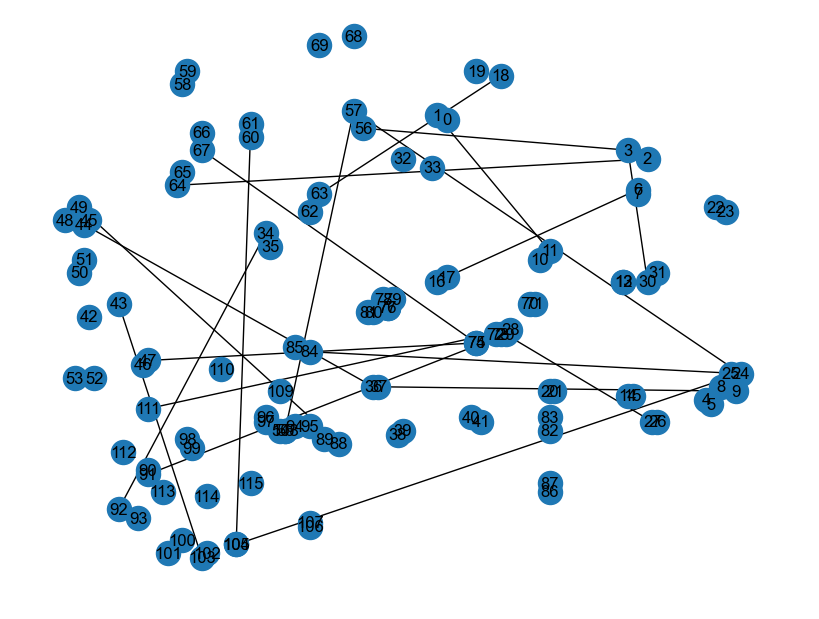

In [372]:
nx.draw(poisson_graph, layout, with_labels=True, linewidths =1)
# plt.title("Grafo Poissoniano")
plt.savefig("static/poissonian_graph.png",bbox_inches='tight', transparent=True)

Simular un grafo small-world con el algoritmo de Watts-Strogatz.

In [373]:
k_watts_strogatz = 4  # Número medio de vecinos
p_watts_strogatz = 0.3  # Probabilidad de reconexión
small_world_graph = nx.watts_strogatz_graph(n, k_watts_strogatz, p_watts_strogatz, seed=RANDOM_STATE)

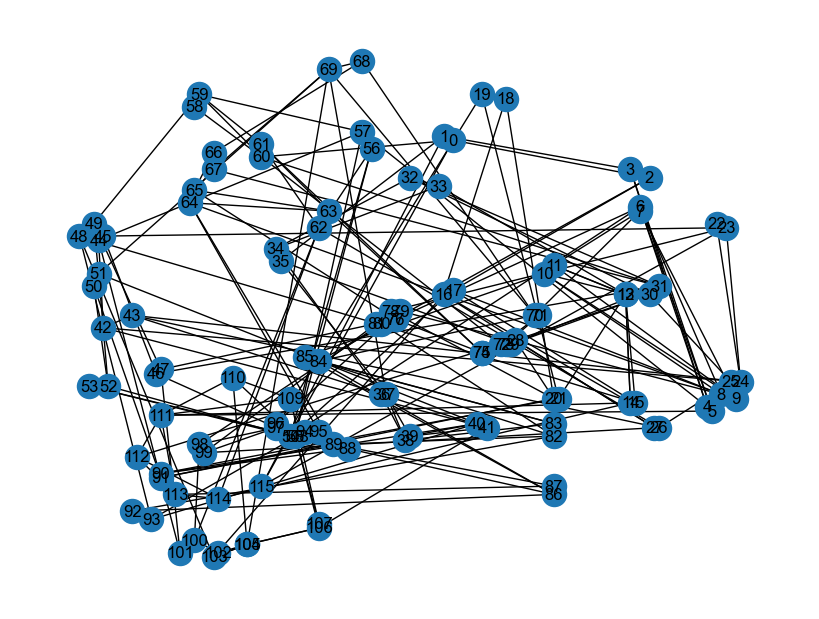

In [374]:
nx.draw(small_world_graph, layout, with_labels=True, linewidths =1)
# plt.title("Grafo Small World")
plt.savefig("static/small_world.png",bbox_inches='tight', transparent=True)

Simular un grafo scale-free con el algoritmo de Barabasi-Albert.

In [375]:
m_barabasi_albert = 5  # Número de enlaces que se agregan en cada paso
scale_free_graph = nx.barabasi_albert_graph(n, m_barabasi_albert, seed=RANDOM_STATE)

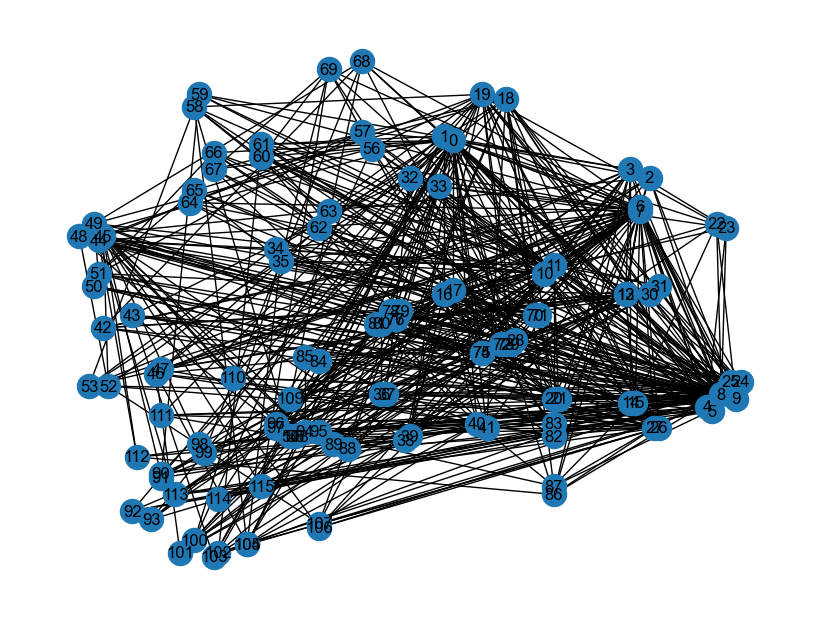

In [376]:
nx.draw(scale_free_graph, layout, with_labels=True, linewidths =1)
# plt.title("Grafo Scale Free")
plt.savefig("static/scale_free.png",bbox_inches='tight', transparent=True)

Visualizar los grafos simulados para cada uno de los prototipos de redes.

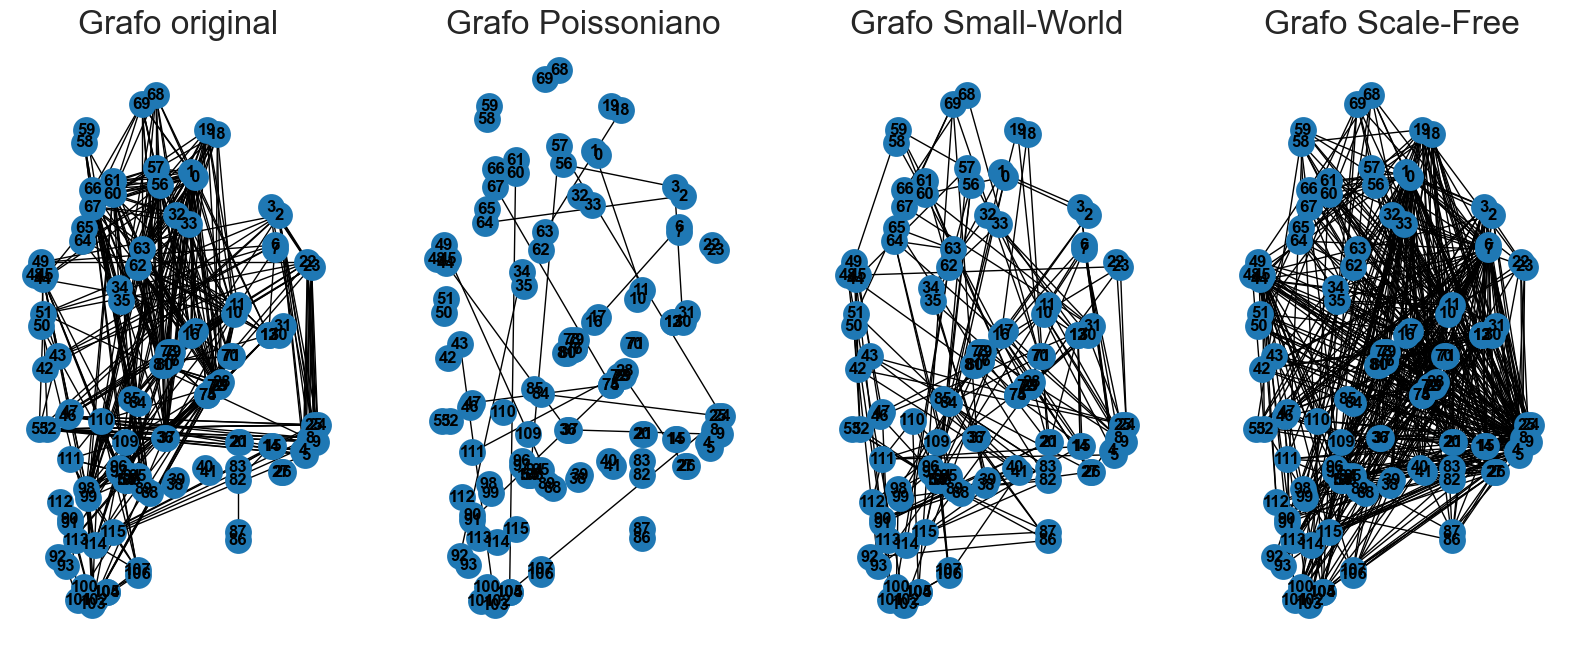

In [377]:
fig, axes = plt.subplots(1,4, figsize=(20, 8))
axes = axes.flat

nx.draw(G, layout, with_labels=True, font_weight='bold', ax=axes[0])
axes[0].set_title('Grafo original')

nx.draw(poisson_graph, layout, with_labels=True, font_weight='bold', ax=axes[1])
axes[1].set_title('Grafo Poissoniano')

nx.draw(small_world_graph, layout, with_labels=True, font_weight='bold',ax=axes[2])
axes[2].set_title('Grafo Small-World')

nx.draw(scale_free_graph, layout, with_labels=True, font_weight='bold', ax=axes[3])
axes[3].set_title('Grafo Scale-Free')

plt.show()

fig.savefig("static/compare_graphs.png", bbox_inches='tight', transparent=True)

- Generar `1000` instancias de grafos para cada uno de dichos prototipos (*poissonianas*, *small-World* y *scale-free*). Para el conjunto de 1000 instancias de cada prototipo, calcular el histograma de coeficientes de $< k >$, $k_{max}$, $C$, y $eff$. Comparar con los valores de coeficientes que obtuvimos para el grafo de datos $G$.

In [378]:
n_instancias = 1000

res = {
    "poisson": {
        "k_mean": [],
        "k_max": [],
        "ci_mean": [],
        "eff": [],
        "p": [],
    },
    "small_world": {
        "k_mean": [],
        "k_max": [],
        "ci_mean": [],
        "eff": [],
        "k": [],
        "p": []
    },
    "scale_free": {
        "k_mean": [],
        "k_max": [],
        "ci_mean": [],
        "eff": [],
        "m": []
    }
}

In [379]:
probs = np.random.normal(n / (m * (n - 1) / 2), 0.1, n_instancias)

for p in probs: 
    graph = nx.erdos_renyi_graph(n, p, seed=RANDOM_STATE)
    k_mean, k_max, ci_mean, eff = get_graph_metrics(graph)
    res["poisson"]["k_mean"].append(k_mean)
    res["poisson"]["k_max"].append(k_max)
    res["poisson"]["ci_mean"].append(ci_mean)
    res["poisson"]["eff"].append(eff)
    res["poisson"]["p"].append(p)

In [380]:
k_watts_strogatz = np.random.binomial(10, 0.5, n_instancias)
p_watts_strogatz = np.random.normal(0.3, 0.1, n_instancias)

for k, p in zip(k_watts_strogatz, p_watts_strogatz): 
    graph = nx.watts_strogatz_graph(n, k, p, seed=RANDOM_STATE)
    k_mean, k_max, ci_mean, eff = get_graph_metrics(graph)
    res["small_world"]["k_mean"].append(k_mean)
    res["small_world"]["k_max"].append(k_max)
    res["small_world"]["ci_mean"].append(ci_mean)
    res["small_world"]["eff"].append(eff)
    res["small_world"]["k"].append(k)
    res["small_world"]["p"].append(p)

In [381]:
for _ in range(n_instancias):
    m = np.random.randint(1, 115)
    graph = nx.barabasi_albert_graph(n, m, seed=RANDOM_STATE)
    k_mean, k_max, ci_mean, eff = get_graph_metrics(graph)
    res["scale_free"]["k_mean"].append(k_mean)
    res["scale_free"]["k_max"].append(k_max)
    res["scale_free"]["ci_mean"].append(ci_mean)
    res["scale_free"]["eff"].append(eff)
    res["scale_free"]["m"].append(m)

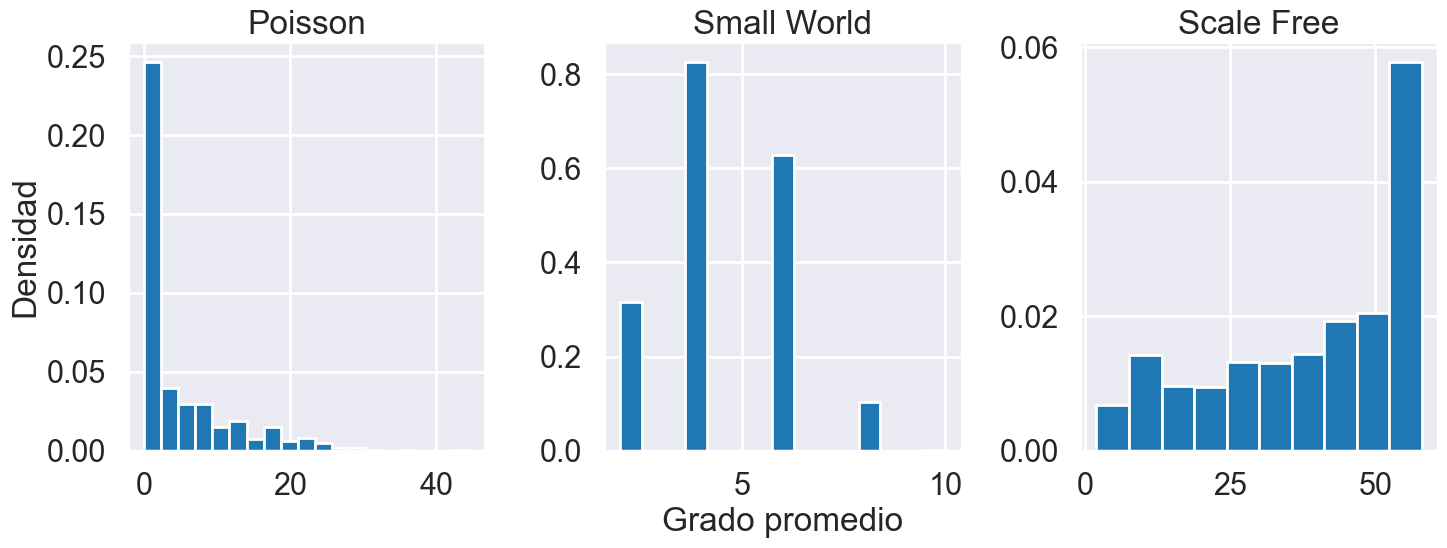

In [382]:
fig, axes = plt.subplots(1,3,figsize=(15,6))
axes = axes.flat

axes[0].hist(res["poisson"]["k_mean"], bins="scott", density=True)
axes[0].set_title('Poisson')
axes[0].set_ylabel('Densidad')

axes[1].hist(res["small_world"]["k_mean"], bins="scott", density=True)
axes[1].set_title('Small World')
axes[1].set_xlabel('Grado promedio')

axes[2].hist(res["scale_free"]["k_mean"], bins="scott", density=True)
axes[2].set_title('Scale Free')

# fig.suptitle('Distribución de grado promedio')

plt.tight_layout()
plt.show()

fig.savefig("static/all_graphs_dist_k_mean.png", bbox_inches='tight', transparent=True)

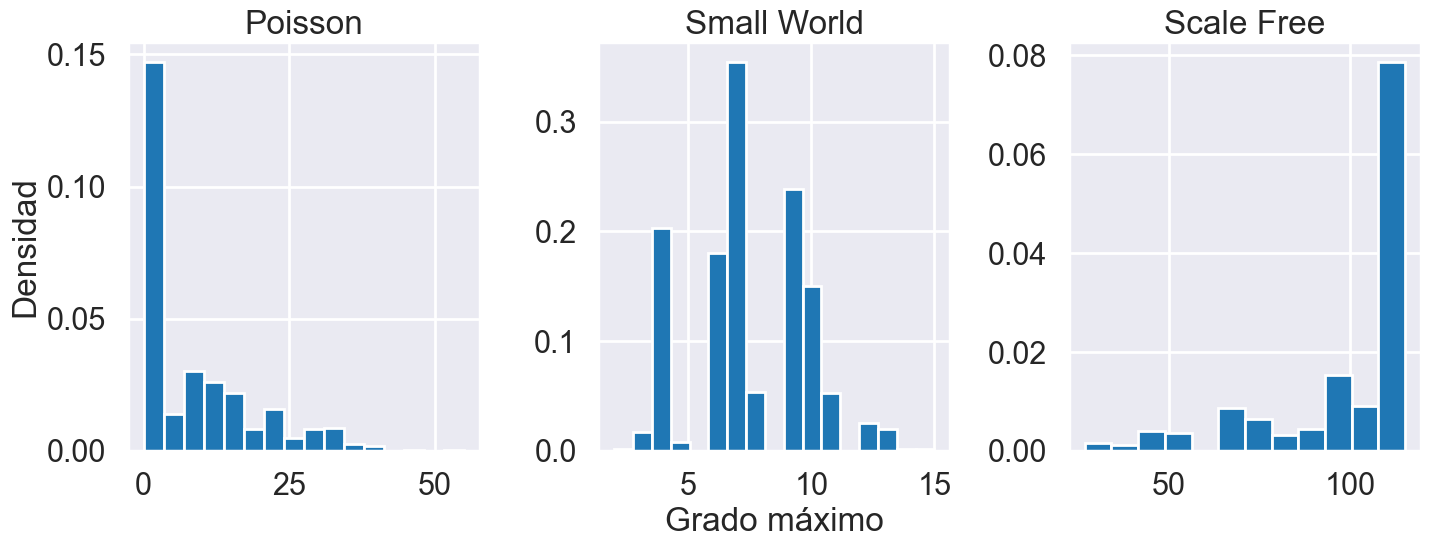

In [383]:
fig, axes = plt.subplots(1,3,figsize=(15,6))
axes = axes.flat

axes[0].hist(res["poisson"]["k_max"], bins="scott", density=True)
axes[0].set_title('Poisson')
axes[0].set_ylabel('Densidad')

axes[1].hist(res["small_world"]["k_max"], bins="scott", density=True)
axes[1].set_title('Small World')
axes[1].set_xlabel('Grado máximo')

axes[2].hist(res["scale_free"]["k_max"], bins="scott", density=True)
axes[2].set_title('Scale Free')

plt.tight_layout()
plt.show()

fig.savefig("static/all_graphs_dist_k_max.png", bbox_inches='tight', transparent=True)

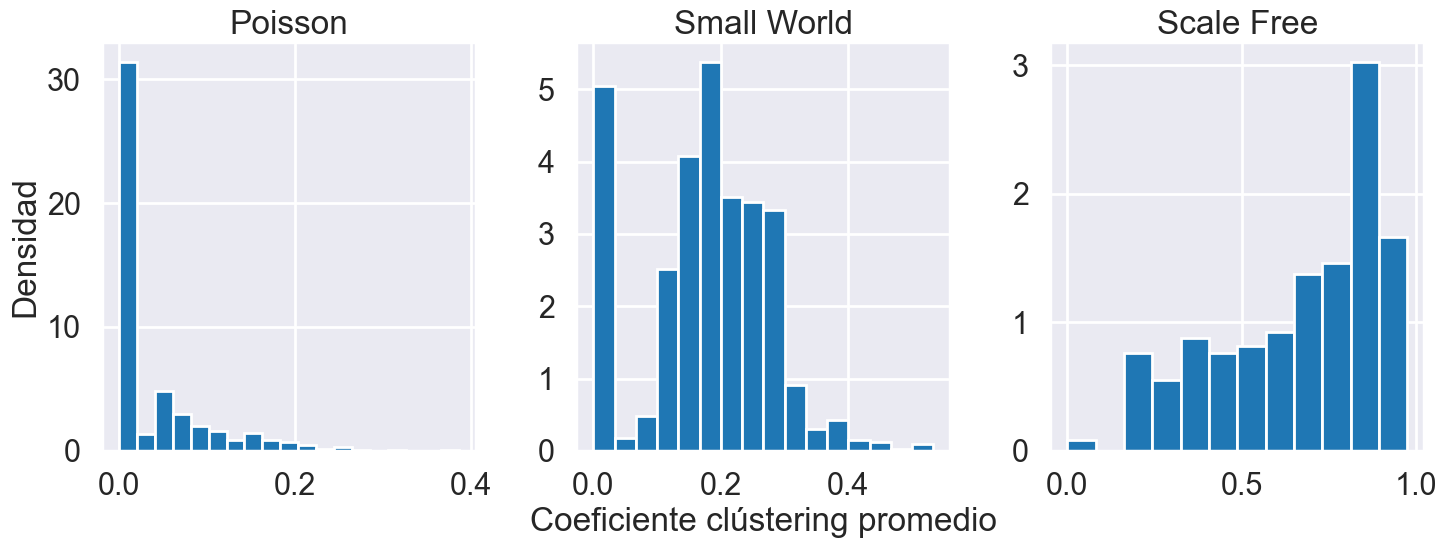

In [384]:
fig, axes = plt.subplots(1,3,figsize=(15,6))
axes = axes.flat

axes[0].hist(res["poisson"]["ci_mean"], bins="scott", density=True)
axes[0].set_title('Poisson')
axes[0].set_ylabel('Densidad')

axes[1].hist(res["small_world"]["ci_mean"], bins="scott", density=True)
axes[1].set_title('Small World')
axes[1].set_xlabel('Coeficiente clústering promedio')

axes[2].hist(res["scale_free"]["ci_mean"], bins="scott", density=True)
axes[2].set_title('Scale Free')

# fig.suptitle('Distribución de coeficiente de clustering promedio')

plt.tight_layout()
plt.show()

fig.savefig("static/all_graphs_dist_ci_mean.png", bbox_inches='tight', transparent=True)

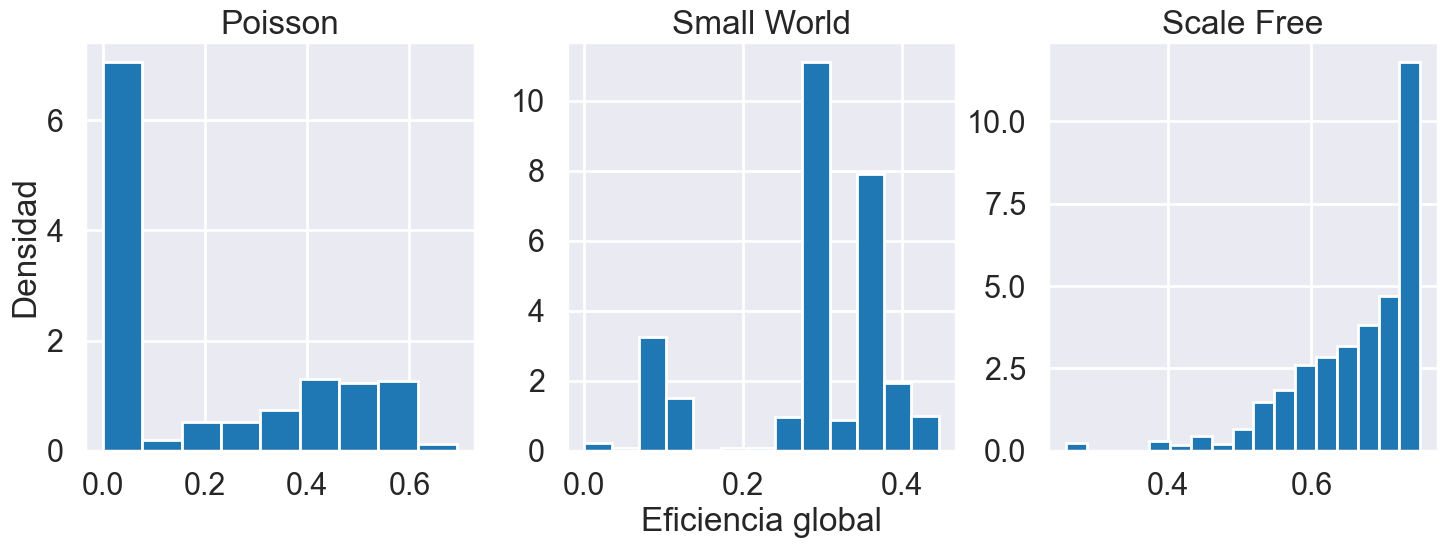

In [385]:
fig, axes = plt.subplots(1,3,figsize=(15,6))
axes = axes.flat

axes[0].hist(res["poisson"]["eff"], bins="scott", density=True)
axes[0].set_title('Poisson')
axes[0].set_ylabel('Densidad')

axes[1].hist(res["small_world"]["eff"], bins="scott", density=True)
axes[1].set_title('Small World')
axes[1].set_xlabel('Eficiencia global')

axes[2].hist(res["scale_free"]["eff"], bins="scott", density=True)
axes[2].set_title('Scale Free')

# fig.suptitle('Distribución de eficiencia global')

plt.tight_layout()
plt.show()

fig.savefig("static/all_graphs_dist_eff.png", bbox_inches='tight', transparent=True)